In [1]:
#!pip install numpy pandas matplotlib seaborn rich scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print as rprint
%matplotlib inline
sns.set()

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (classification_report, roc_curve, roc_auc_score, 
                             recall_score, f1_score, precision_score, accuracy_score)

## toxcast

#### Loading the data

In [3]:
#preprocessed dataset
tox_cast = pd.read_csv('final_toxcast_3.csv')

In [4]:
tox_cast.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,label
0,0.975099,0.013842,5.438167e-01,5.346966e-01,6.893569e-07,0.212674,0.117444,2.509948e-11,8.947108e-01,5.856109e-17,...,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.307979,0.0
1,0.996567,0.006574,9.228296e-01,2.175235e-08,6.893569e-07,0.100218,0.019674,2.509948e-11,9.258417e-11,5.856109e-17,...,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.673632,0.0
2,0.627583,0.010335,4.074888e-10,2.648697e-01,6.893569e-07,0.100218,0.323450,8.085811e-01,8.568377e-01,5.856109e-17,...,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.591018,0.0
3,0.975099,0.013568,5.438167e-01,5.346966e-01,6.893569e-07,0.212674,0.135223,2.509948e-11,8.947108e-01,5.856109e-17,...,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.187246,0.0
4,0.975099,0.013472,5.438167e-01,5.346966e-01,6.893569e-07,0.405153,0.019674,2.509948e-11,8.947108e-01,5.856109e-17,...,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.317261,0.0


In [5]:
y = tox_cast['label'].to_numpy().flatten()
X = tox_cast.drop(columns=['label'], inplace=False).to_numpy()
rprint(X.shape, y.shape)

(7831, 135)
(7831,)

In [6]:
np.unique(y)

array([0., 1.])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
scaler = StandardScaler().fit(X_train)

#### Logistic Regression

In [8]:
#building the model
logistic_regression = LogisticRegression(max_iter=1000)

In [9]:
#train
logistic_regression.fit(scaler.transform(X_train), y_train)

LogisticRegression(max_iter=1000)

In [10]:
#evaluation
y_pred = logistic_regression.predict(scaler.transform(X_test))

In [11]:
def generate_report(y_pred, y_test, title='model', target_names=['0', '1']):
    """
        function to generate appropriate report based on predictions
    """
    rprint('[red]' + title + f" [black]recall score = {recall_score(y_test, y_pred):.4f}")
    rprint('[red]' + title + ' [black]classification report:')
    rprint(classification_report(y_test, y_pred, target_names=target_names))
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'b-')
    plt.grid(True)
    plt.title(title + f' Roc Curve auc_score = {auc:.2f}')
    plt.show()

Logistic Regression recall score = 0.4198

Logistic Regression classification report:

precision    recall  f1-score   support

           0       0.85      0.95      0.90      1224
           1       0.69      0.42      0.52       343

    accuracy                           0.83      1567
   macro avg       0.77      0.68      0.71      1567
weighted avg       0.82      0.83      0.82      1567

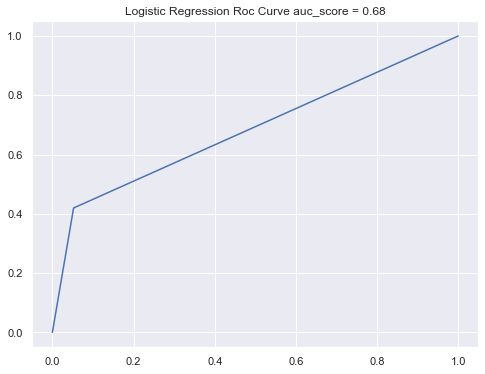

In [12]:
#report
generate_report(y_pred, y_test, 'Logistic Regression')

##### Cross-Validation 

In [13]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
fprs = []
tprs = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
for train_indx, test_indx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train, y_train = X[train_indx], y[train_indx]
    X_test, y_test = X[test_indx], y[test_indx]
    scaler.fit(X_train)
    #building the model
    logistic_regression = LogisticRegression(max_iter=1000)
    #train
    logistic_regression.fit(scaler.transform(X_train), y_train)
    #evaluation
    y_pred = logistic_regression.predict(scaler.transform(X_test))
    f, t, _ = roc_curve(y_test, y_pred)
    fprs.append(f)
    tprs.append(t)
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))


In [14]:

def generate_cv_results(fprs, tprs, accuracies, recalls, precisions, f1_scores, title):
    df = pd.DataFrame.from_dict({"k":range(1, len(accuracies) + 1),
                                'accuracy':accuracies,
                                'recall':recalls,
                                'precision':precisions,
                                'f1':f1_scores})
    plt.figure(figsize=(12, 10))
    for k, (f, t) in enumerate(zip(fprs, tprs)):
        plt.plot(f, t, label=f'k={k+1}')
    plt.title(title + ' Roc Curve')
    plt.legend(loc='best')
    plt.show()
    
    return df
    

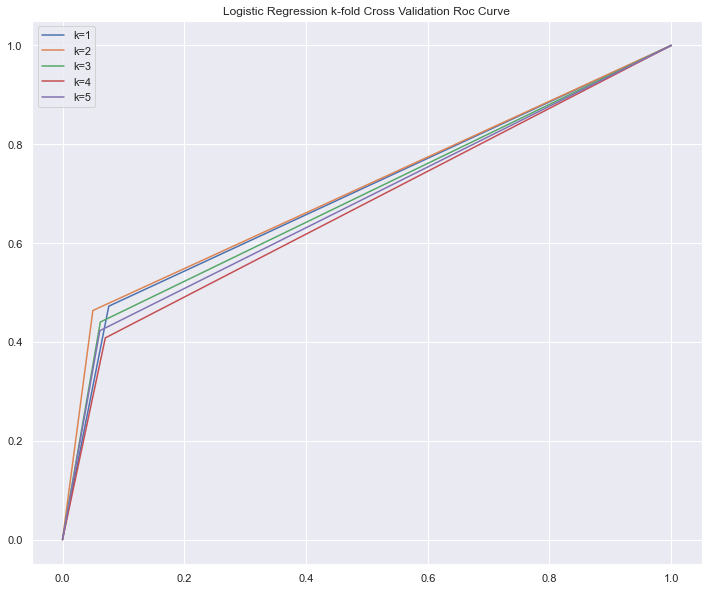

In [15]:
df_lgr = generate_cv_results(fprs, tprs, accuracies, recalls, precisions, f1_scores, 'Logistic Regression k-fold Cross Validation')

In [16]:
rprint("[red]Logistic Regression's cross validation scores")
df_lgr

Logistic Regression's cross validation scores

,k,accuracy,recall,precision,f1
0,1,0.825144,0.472303,0.635294,0.541806
1,2,0.843550,0.463557,0.722727,0.564831
2,3,0.828863,0.440233,0.665198,0.529825
3,4,0.815453,0.408163,0.619469,0.492091
4,5,0.825670,0.422741,0.659091,0.515098


#### Perceptron

In [17]:
#building the model
perceptron = Perceptron()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
scaler = StandardScaler().fit(X_train)

In [19]:
#train
perceptron.fit(scaler.transform(X_train), y_train)

Perceptron()

In [20]:
#evaluation
y_pred = perceptron.predict(scaler.transform(X_test))

Perceptron recall score = 0.4665

Perceptron classification report:

precision    recall  f1-score   support

           0       0.85      0.86      0.86      1224
           1       0.49      0.47      0.48       343

    accuracy                           0.78      1567
   macro avg       0.67      0.67      0.67      1567
weighted avg       0.77      0.78      0.77      1567

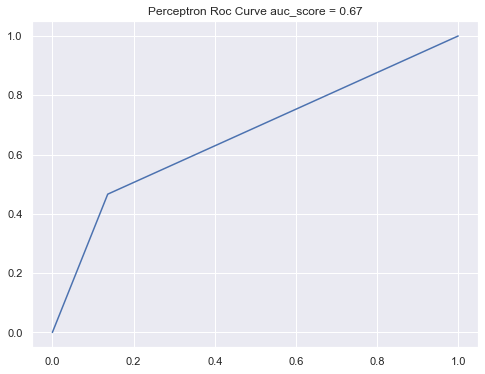

In [21]:
generate_report(y_pred, y_test, 'Perceptron')

##### Cross Validation

In [22]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
fprs = []
tprs = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
for train_indx, test_indx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train, y_train = X[train_indx], y[train_indx]
    X_test, y_test = X[test_indx], y[test_indx]
    scaler.fit(X_train)
    #building the model
    perceptron = Perceptron()
    #train
    perceptron.fit(scaler.transform(X_train), y_train)
    #evaluation
    y_pred = perceptron.predict(scaler.transform(X_test))
    f, t, _ = roc_curve(y_test, y_pred)
    fprs.append(f)
    tprs.append(t)
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))


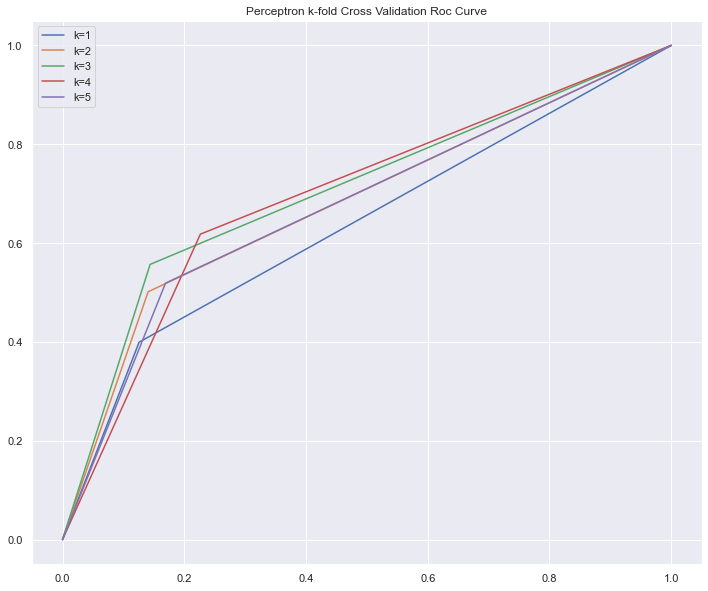

In [23]:
df_per = generate_cv_results(fprs, tprs, accuracies, recalls, precisions, f1_scores, 'Perceptron k-fold Cross Validation')

In [24]:
rprint("[red]Perceptron's cross-validation results")
df_per

Perceptron's cross-validation results

,k,accuracy,recall,precision,f1
0,1,0.770262,0.399417,0.470790,0.432177
1,2,0.780971,0.501458,0.500000,0.500728
2,3,0.790549,0.556851,0.520436,0.538028
3,4,0.739464,0.618076,0.433538,0.509615
4,5,0.762452,0.518950,0.462338,0.489011
